<a href="https://colab.research.google.com/github/ccg-esb/EvK/blob/main/py_pOXA48_SI3_multistrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. Modeling plasmid dynamics in multistrain communities


For each strain $i$, we denote the densities of plasmid-bearing and plasmid-free subpopulations as $B_{pi}$ and $B_i$, respectively. The entire bacterial community at a given time $t$ can be symbolically expressed as a vector: $\mathbf{B}(t) = (B_{p1}(t), B_{p2}(t), ..., B_{pM}(t), B_1(t), B_2(t), ..., B_M(t))$.

As each cell consumes the limiting resource at rates defined by their individual growth kinetic parameters, the rate of resource $R$ change over time is dictated by:
$$
\frac{{dR}}{{dt}} = -\sum_{i=1}^{M} (u_{pi}(R(t))B_{pi}(t) + u_i(R(t))B_i(t)) - dR.
$$

We postulate that antibiotic molecules are deactivated at a rate proportional to the total bacterial population and the environmental drug concentration. This is mathematically represented as:
$$
\frac{{dA}}{{dt}} = -\sum_{i=1}^{M} (B_{pi}(t) + B_i(t)) - dA.
$$

Given that plasmid conjugation is contingent on the recipient cell, the strain $i$'s receptiveness towards the pOXA-48 plasmid is defined by $i$. Therefore, the plasmid-bearing subpopulation's growth of strain $i$ hinges on the collective contribution of all plasmid-bearing populations:
$$\frac{{dB_{pi}}}{{dt}} = p_iu_{pi}(R)(1 - p_iA)B_{pi} + \sum_{j=1}^{M} B_{pj} - dB_{pi}.$$

Likewise, the population dynamics of the plasmid-free strain $i$ can be captured as:
$$\frac{{dB_i}}{{dt}} = u(R)(1 - A)B_i + p_iu_{pi}(R)B_{pi} - \sum_{j=1}^{M} B_{pj} - dB_i.$$

The initial conditions for the simulations stem from a competition experiment where all strains in the community, both plasmid-bearing and plasmid-free, are introduced at equivalent initial densities at time $t=0$. Simulations were conducted in Matlab employing standard numerical solvers and scientific libraries.

In [1]:
import os
import operator
import numpy as np
import pandas as pd
import sys
import colorcet as cc
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [6]:

def dB_conj(B_WT, B_TC, conj_rate):
    if np.isnan(conj_rate): # Below detectable limits
        conj_rate = 0
    ret = 0
    if np.size(B_TC) == 1:
        ret = conj_rate * B_WT * B_TC  # Changed Bdonor to B_TC because in this case B_TC is a float
    else:
        for Bdonor in B_TC:
            ret += conj_rate * B_WT * Bdonor
    return ret

def fMultistrain(t, y, params):
    S = y[0]
    A = y[1]
    num_strains = int(len(params['strain']) / 2)
    B_TC = y[2:num_strains + 2]
    B_WT = y[num_strains + 2:]

    uStot = 0
    dB = np.zeros(2 * num_strains)

    # For plasmid-bearing (TC)
    for i in range(num_strains):

        uSi_TC = uS(S, params['VKm'].iloc[i])
        uStot += uSi_TC * B_TC[i]

        dB_TC_growth = params['rho'].iloc[i] * uSi_TC * B_TC[i]
        dB_TC_seg = params['rho'].iloc[i] * uSi_TC * B_TC[i] * params['seg_rate'].iloc[i]

        db_MIC_TC = params['kappa'].iloc[i]
        dB_TC_kill = dB_kill(A, B_TC[i], db_MIC_TC, params.attrs['A_max'])

        conj_permissiveness=params['conj_rate'].iloc[i+num_strains] #permissiveness of WT
        dB_TC_conj = dB_conj(B_WT[i], B_TC, conj_permissiveness)


        dB[i] = dB_TC_growth + dB_TC_conj - dB_TC_seg - dB_TC_kill

    # For plasmid-free (WT)
    for i in range(num_strains, 2*num_strains):

        uSi_WT = uS(S, params['VKm'].iloc[i])
        uStot += uSi_WT * B_WT[i-num_strains]

        dB_WT_growth = params['rho'].iloc[i] * uSi_WT * B_WT[i-num_strains]

        db_MIC_WT = params['kappa'].iloc[i]
        dB_WT_kill = dB_kill(A, B_WT[i-num_strains], db_MIC_WT, params.attrs['A_max'])

        uSi_TC = uS(S, params['VKm'].iloc[i-num_strains])
        dB_WT_seg= params['rho'].iloc[i - num_strains] * uSi_TC * B_TC[i - num_strains] * params['seg_rate'].iloc[i-num_strains]

        conj_permissiveness=params['conj_rate'].iloc[i] #permissiveness of WT
        dB_WT_conj = dB_conj(B_WT[i-num_strains], B_TC, conj_permissiveness)

        dB[i] = dB_WT_growth - dB_WT_conj - dB_WT_kill + dB_WT_seg

    dS =  - uStot
    dA = -A * (params.attrs['alphas'][0] * np.sum(B_TC) + params.attrs['alphas'][1] * np.sum(B_WT))

    return np.concatenate(([dS], [dA], dB))


In [ ]:
def simulate_multistrain(this_params, istrains, y0):
    #get_values = operator.itemgetter(*istrains)
    #selected_strains = get_values(strains)
    #strains_params = get_strains_params(model_params, selected_strains)
    strains_params=get_selected_strains_params(this_params, istrains)

    num_strains = int(len(strains_params['strain']) / 2)

    # Set initial conditions
    S0 = this_params.attrs['S0']
    B0 = this_params.attrs['B0']

    t_span = [0, this_params.attrs['T']]

    # Solve the ODE
    sol = solve_ivp(fMultistrain, t_span, y0, args=(strains_params,), method='BDF', max_step=0.1, rtol=1e-5, atol=1e-8)

    # Extract the time points and solution vectors
    times = sol.t
    ys = sol.y

    return times, ys, strains_params

### Load model parameters

In [2]:

# Define your paths
root='/content/drive/MyDrive/SYNC_Projects/pOXA48/2023/code/py-files/'

path='./'
figPath = path+'figures/'
envPath = path+'env/'
dataPath = path+'data/'

strains_subsetE = [1, 2, 6, 9, 11, 15, 18, 20, 21, 24]
strains_subsetK = [25, 26, 29, 34, 37, 38, 39, 41, 43, 45]

strains_subset = strains_subsetE + strains_subsetK

print("subset: ",strains_subset)

strains = ['C001', 'C002',  'C006',  'C011',  'C012',  'C021',  'C022',  'C031',  'C051',  'C063',  'C094',  'C107',  'C115',  'C131',  'C141',  'C201',  'C227',  'C232',  'C247',  'C261',  'C286',  'C290',  'C302',  'C309',  'C324',  'K037',  'K038',  'K087',  'K094',  'K112',  'K114',  'K125',  'K141',  'K168',  'K177',  'K200',  'K201',  'K209',  'K213',  'K216',  'K224',  'K225',  'K241',  'K248',  'K249',  'K253',  'K257',  'K275',  'K285',  'K300']
plasmids = ['WT','TC']

tot_strains = int(len(strains))
cmap_strains = cc.glasbey_light[:tot_strains]


subset:  [1, 2, 6, 9, 11, 15, 18, 20, 21, 24, 25, 26, 29, 34, 37, 38, 39, 41, 43, 45]


In [3]:

B0 = 1e6 #Initial bacterial density
T = 24 #Duration of experimental season
S0 = 1 #Concentration of imiting resource
extinction_threshold=1 #Extinction threshold
alphas=[1e-10, 1e-12] #Antibiotic degradation rate
d=0.1 #Transfer dilution rate
A_max=65536*2 #Maximum antibiotic concentrations=[32768, 256, 1024, 32]

expe_params = {
    'B0': B0, #Initial bacterial density
    'A_max': A_max, #Maximum drug concentration
    'alphas': np.array(alphas), #Antibiotic degradation rate
    'T': T,  # Length of experiment
    'S0': S0,  # Resource concentration
    'd': d, #Transfer dilution rate
    'extinction_threshold': extinction_threshold,
}


In [4]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir(root)
sys.path.insert(0, 'src/')
from pOXA48_S1 import *
from pOXA48_S2 import *

Mounted at /content/drive


In [5]:
model_params = import_model_params("%smodel_params.csv"%(dataPath), expe_params)

display_model_params_stats(model_params)

╒═════════╤═════════════╤═══════════════════════╤════════════════════════════════════════════╤═════╕
│ Group   │ Parameter   │ Mean                  │ Range                                      │ N   │
╞═════════╪═════════════╪═══════════════════════╪════════════════════════════════════════════╪═════╡
│ E-TC    │ conj_rate   │ nan                   │ (nan, nan)                                 │ 25  │
├─────────┼─────────────┼───────────────────────┼────────────────────────────────────────────┼─────┤
│ E-TC    │ VKm         │ 6.3164e-10            │ (3.79e-10, 8.37e-10)                       │ 25  │
├─────────┼─────────────┼───────────────────────┼────────────────────────────────────────────┼─────┤
│ E-TC    │ rho         │ 842358780.8           │ (506376720.0, 1071282240.0)                │ 25  │
├─────────┼─────────────┼───────────────────────┼────────────────────────────────────────────┼─────┤
│ E-TC    │ seg_rate    │ 0.7843146083017115    │ (0.41282435738322215, 1.5263650048538724)

In [7]:
def get_selected_strains_params(model_params, istrains):
    num_strains = int(len(model_params) / 2)

    indices_tc = model_params.loc[(model_params.index.isin(istrains)) & (model_params['type'] == 'TC')].index
    indices_wt = indices_tc + num_strains

    output = pd.DataFrame()

    for key in model_params.columns:
        if key == 'type':
            output[key] = ['TC'] * len(indices_tc) + ['WT'] * len(indices_wt)
        else:
            output[key] = model_params.loc[indices_tc, key].tolist() + model_params.loc[indices_wt, key].tolist()

    output.attrs = model_params.attrs
    return output


## Stochastic environments

In order to model different environmental regimes and population structures, we performed computer simulations involving numerical solutions of the population dynamics model. We used a dedicated Python package for generating stochastic environments, which accommodates the generation of various stochastic processes such as continuous, discrete, diffusion, and noise methods.

To emulate environments with varying levels of selection pressure, we adjusted a stochastic time series by multiplying it with a constant, $0 \leq A \leq \text{max}(1)$, where this constant signifies the maximum selection pressure exerted by the environment. We performed specific numerical experiments in which the daily drug concentration was established using Gaussian signal noise, characterized by a probability density function equivalent to the normal distribution.

In [8]:
def load_environment(str_E, indx_E, envPath, numDays):
    this_csv = f'{str_E}_{indx_E}.csv'
    path_csv = os.path.join(envPath, str_E)

    #print(f'Loading {this_csv}')
    T = pd.read_csv(os.path.join(path_csv, this_csv))
    E_sample = T.iloc[:, 0].values
    E = (E_sample - E_sample.min()) / (E_sample.max() - E_sample.min())
    E = E[:numDays]

    return E

# Load environments
def load_environments(str_E, envPath, num_days, iEs):

  Es = []
  for indx_E in iEs:
      E = load_environment(str_E, indx_E, envPath, num_days)
      Es.append(E)
  return Es


In [9]:


def plot_environment(E, Emax=1, str_E=''):
    cmap = plt.get_cmap('gray_r')  # Choose the colormap (gray)
    num_days = len(E)
    norm = mcolors.Normalize(vmin=0, vmax=Emax)  # Normalize colors to range [0, 1]

    plt.figure(figsize=(10, 1))
    plt.imshow([E], cmap=cmap, norm=norm, aspect='auto', extent=[0, len(E)+1, 0, 1])
    plt.xticks(np.arange(0, num_days + 1)+0.5, np.arange(0, num_days + 1))  # Shift x-ticks by 0.5
    plt.xlabel('Time (days)')
    plt.xlim([0, num_days+1])
    plt.ylabel('')
    plt.title(str_E)
    plt.show()


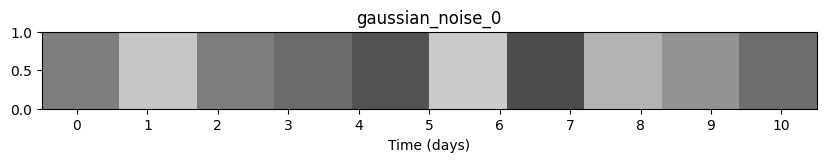

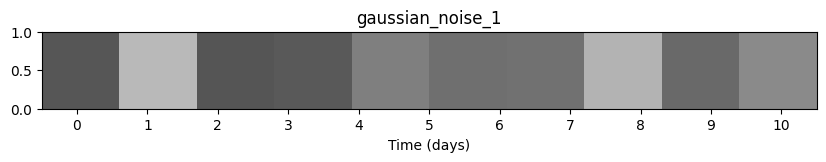

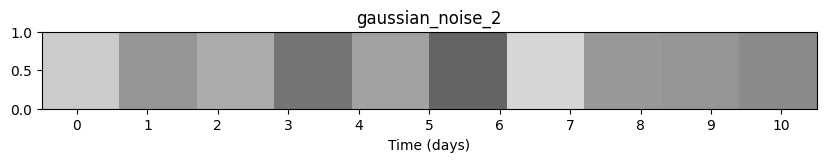

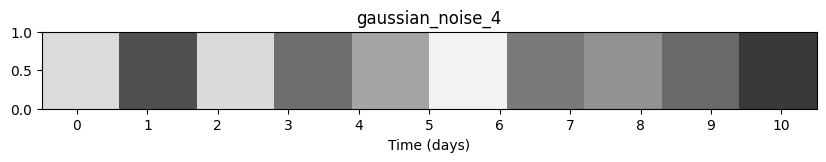

In [10]:

num_days = 10
str_E = 'gaussian_noise'
iEs = [0, 1, 2, 4]
Es=load_environments(str_E, envPath, num_days, iEs)

# Plot the environments
for indx_E, E in zip(iEs, Es):
    lbl_E = f'{str_E}_{indx_E}'
    plot_environment(E, 1, lbl_E)


## Multistrain / Multiday (random environment)

Serial dilution experiments are a key methodology in microbiology, enabling the study of microbial growth, survival, and behavior under varying environmental conditions. These experiments are cyclical, consisting of the incubation of microbial cultures, followed by their dilution, and then a subsequent growth phase. To model this process, where multiple bacterial strains compete for space and a single limiting resource, we use numerical simulations. In this simulation, $S$ represents the growth medium that supports bacterial proliferation, while $E$ designates an ordered series of antibiotic concentrations applied sequentially on each day of the experiment.

In the initial conditions of the experiment, a bacterial population is introduced into a medium abundant in substrate and exposed to an initial antibiotic concentration 'A'. To simulate a scenario of plasmid invasion, it is assumed that all bacteria are initially devoid of plasmids, with the exception of a single strain carrying a plasmid. Therefore, we denote the substrate concentration 'S' is initialized to 'S0', the initial antibiotic concentration is set to 'A', the plasmid-carrying bacteria (type-TC) for each strain are initialized to '0', and the plasmid-free bacteria (type-WT) for each strain are evenly distributed to sum to 'B0'. The plasmid-carrying bacteria of the first strain is then set to 'B0', signifying the start of the plasmid invasion.

From the second day onward, the system undergoes a daily 'serial dilution' simulation. This operation involves reducing the bacterial population from the previous day by a factor 'd', an action that imitates the constraints posed by limited resources. Subsequently, the system is replenished with fresh substrate up to a fixed level 'S0'. Post dilution, the bacteria are subjected to growth in the presence of a new antibiotic concentration.

This iterative sequence of growth, dilution, and regrowth extends over a predetermined number of days. The simulation tracks the progression of bacterial population dynamics, documenting the changes in the densities of various bacterial strains over time. The introduction of an antibiotic exerts a selective pressure that may benefit resistant strains. This setup offers valuable insights into the dynamics between bacterial growth, plasmid transfer, and antibiotic resistance.

In [11]:
def simulateTransfers(model_params, istrains, E):
    times_list = []
    ys_list = []
    strains_params_list = []
    num_strains = len(istrains)

    print("E=%s"%E)
    for day in range(len(E)):
        A = E[day]

        if day == 0:
            #yi = np.concatenate(([S0], [A], B0 * np.ones(2 * num_strains) / (num_strains * 2))) #Competition experiment

            istrains_TC0 = np.zeros(num_strains)
            istrains_WT0 = B0 * np.ones(num_strains) / num_strains

            # Concatenate the arrays
            yi = np.concatenate(([S0], [A], istrains_TC0, istrains_WT0))
            yi[2]=B0 #Plasmid invasion

        else:
            yi = ys[:, -1] * model_params.attrs['d']  # Serial dilution
            yi[0] = model_params.attrs['S0']  # Replenish media

        times, ys, strains_params = simulate_multistrain(model_params, istrains, yi)

        # Check for extinct strains and set their densities to zero
        #for i, y in enumerate(ys[1:], start=1):
        #    if np.any(y < expe_params['extinction_threshold']):
        #        ys[i] = 0

        times_list.append(times)
        ys_list.append(ys)
        strains_params_list.append(strains_params)

    return times_list, ys_list, strains_params_list


In [12]:


def plotTransfers(t_list, ys_list, strains_params_list):
    num_strains = int(len(strains_params_list[0]['strain']) / 2)
    cmap_strains = cc.glasbey_light[:num_strains]
    num_days = len(t_list)

    plt.figure(figsize=(10, 4))
    for day in range(len(t_list)):
        t = t_list[day] + day * model_params.attrs['T']  # Add 'day' to each time point
        ys = ys_list[day]
        strains_params = strains_params_list[day]

        S = ys[0]
        B_TC = ys[2:num_strains + 2]
        B_WT = ys[num_strains + 2:]

        for i in range(len(B_WT)):
            if day == 0:  # Display legend only for the first iteration
                plt.plot(t, B_WT[i], ':', color=cmap_strains[i]) #, label=f'{codes[i]}'
            else:
                plt.plot(t, B_WT[i], ':', color=cmap_strains[i])

        for i in range(len(B_TC)):
            if day == 0:  # Display legend only for the first iteration
                plt.plot(t, B_TC[i], '-', color=cmap_strains[i]) #, label=f'{codes[i]} (TC)'
            else:
                plt.plot(t, B_TC[i], '-', color=cmap_strains[i])

    plt.xlim([0, num_days*model_params.attrs['T']])
    plt.xlabel('Time (hours)')
    plt.ylabel('Density (cells/ml)')
    plt.ylim([0, 1e9])
    plt.legend()
    plt.show()


In [13]:
def get_final_points(times_list, ys_list):
    final_times = []
    final_ys = []

    for day in range(len(times_list)):
        t = times_list[day]
        ys = ys_list[day]
        final_time = t[-1]  # Get the last time point
        final_y = ys[:, -1]  # Get the last solution vector
        final_times.append(final_time)
        final_ys.append(final_y)

    return final_times, final_ys


In [14]:
def analyze_simulation(final_ys):
    num_strains=int((len(final_ys[0])-2)/2)
    B = np.array(final_ys)
    num_days = B.shape[0]
    num_genes = B.shape[1] // 2

    BpT = np.sum(B[:, :num_genes], axis=1)
    BfT = np.sum(B[:, num_genes:], axis=1)

    freqpT = BpT / (BpT + BfT)

    return BpT, BfT, freqpT


In [15]:
def plotTransfersFinalPoint(t_list, ys_list, strains_params_list):
    num_strains = int(len(strains_params_list[0]['strain']) / 2)
    num_days = len(t_list)
    cmap_strains = cc.glasbey_light[:num_strains]

    plt.figure(figsize=(10, 4))
    t = np.arange(num_days)

    for i in range(num_strains):
        B_WT_day = []
        B_TC_day = []
        for day in range(num_days):
            ys = ys_list[day]
            strains_params = strains_params_list[day]

            B_TC = ys[2:num_strains + 2]
            B_WT = ys[num_strains + 2:]

            B_WT_day.append(B_WT[i, -1])
            B_TC_day.append(B_TC[i, -1])

        plt.plot(t, B_WT_day, ':', color=cmap_strains[i]) #, label=f'{codes[i]} (WT)'
        plt.plot(t, B_TC_day, '-', color=cmap_strains[i]) #, label=f'{codes[i]} (TC)'

    plt.xlim([0, num_days])
    plt.xlabel('Time (days)')
    plt.ylabel('Density (cells/ml)')
    plt.ylim([0, 1e9])
    plt.legend()
    plt.show()


Here we run the simulation:

E=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


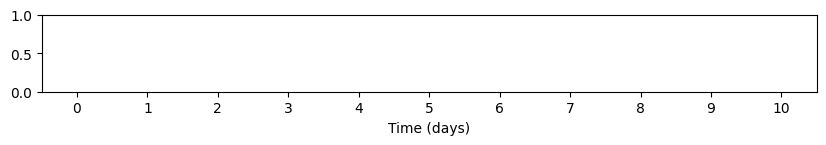

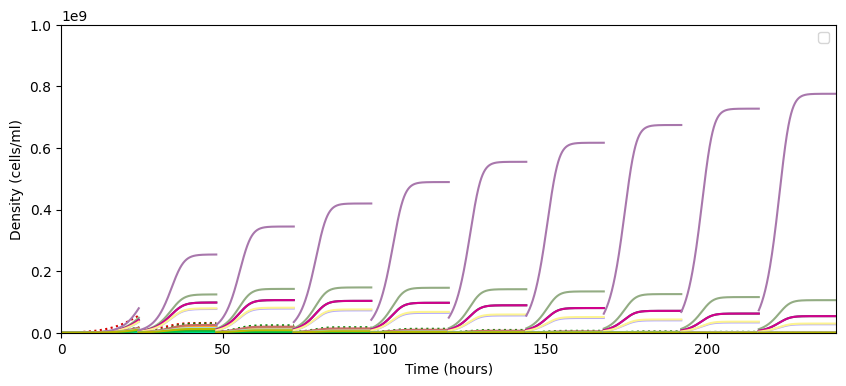

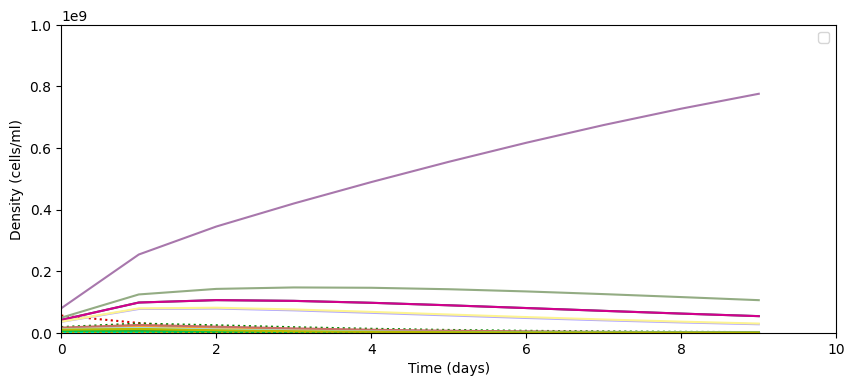

E=[ 8.09937232  3.57817296  8.16815625  9.28116162 10.79299254  3.28458103
 11.18840441  4.76183552  6.76406423  9.17298361]


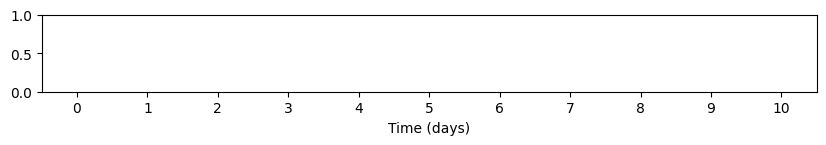

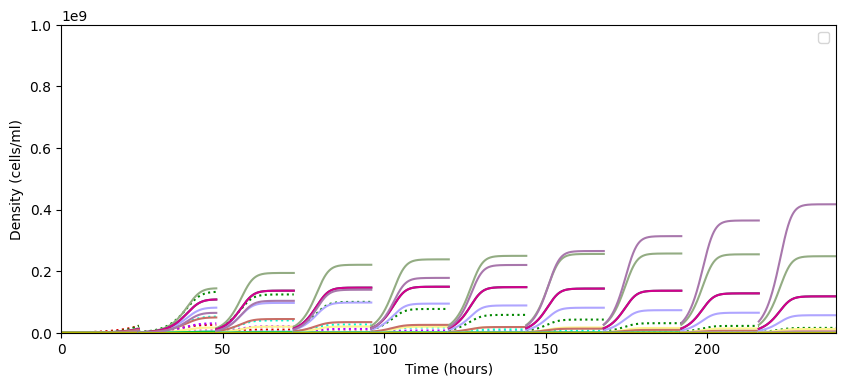

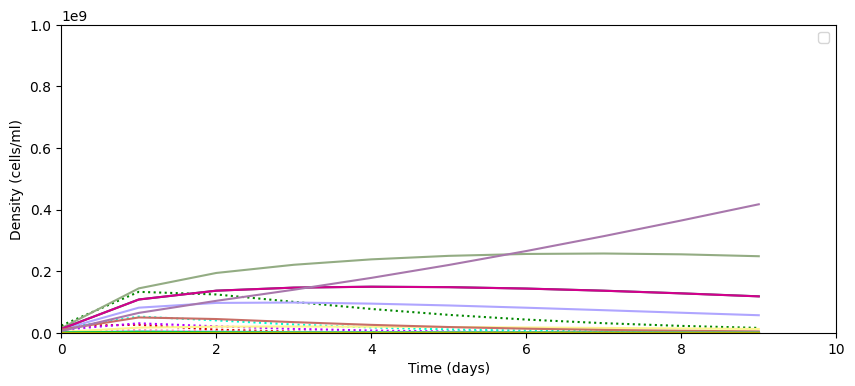

E=[33175.02902881 14656.19644032 33456.76799595 38015.63797539
 44208.09744551 13453.64390297 45827.70447247 19504.47827435
 27705.6071015  37572.54087702]


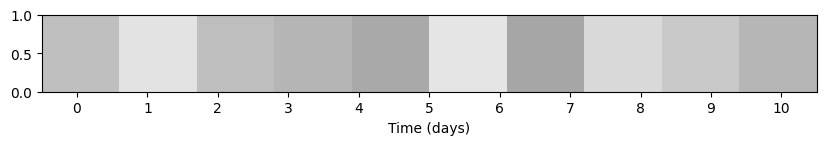

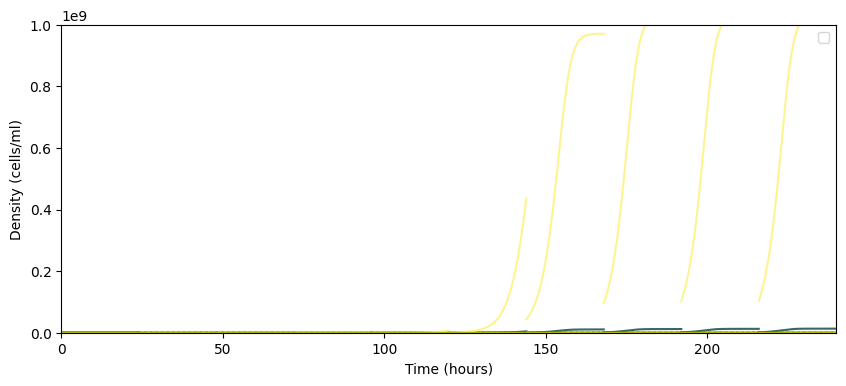

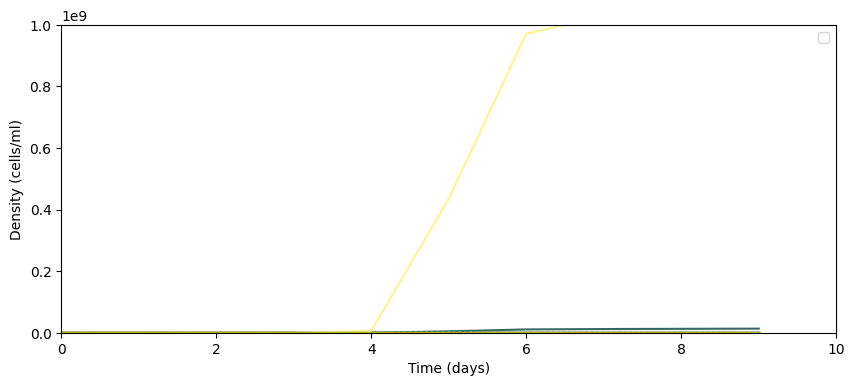

In [16]:
istrains = strains_subset  # List of strains

numDays=10

Amax_values = [0, 2**4, 2**16]
E_values=[]
for Amax in Amax_values:

  #E=Amax*np.ones(numDays) #Constant environment
  E = Amax*Es[0]  # Random Environment

  E_values.append(E)

  #this_params=get_selected_strains_params(istrains, model_params)

  times_list, ys_list, strains_params_list = simulateTransfers(model_params, istrains, E)

  # Plot the environment
  #plot_environment(E,A_max)

  # Plot the transfer curves
  plotTransfers(times_list, ys_list, strains_params_list)

  # Plot the final points
  plotTransfersFinalPoint(times_list, ys_list, strains_params_list)

## Multidose / Multistrain / Multiday (Random Environment)

In [17]:

def simulate_doseResponse_multistrain(model_params, istrains1, Amax_values, y0):
    yT = []
    for this_Amax in Amax_values:
        y0[1] = this_Amax  # initial antibiotic concentration
        times, ys, strain_params = simulate_multistrain(model_params, istrains1,  y0)
        end_point_densities = ys[:, -1]
        yT.append(end_point_densities)

    return yT


istrains1 = [0] #np.arange(len(strains_subset))
Amax=0.04 #Environmental drug concentration
numA=3;


y0 = np.concatenate(([S0],[0.], [B0, B0])) #tmp

Amax_values = np.linspace(0, 0.04, numA)  # Define the range of Amax values
yT=simulate_doseResponse_multistrain(model_params, istrains1, Amax_values, y0)
yT_array = np.array(yT)  # Convert yT to a NumPy array

In [18]:

def plot_doseResponse_multistrain(model_params, istrains, A_values, densities, ax):


    num_strains=int(len(istrains))
    cmap_strains = cc.glasbey_light[:tot_strains]


    #plt.figure(figsize=(6, 4))

    # Convert densities to a NumPy array
    densities = np.array(densities)

    # Plot WT strains with dotted lines
    for i, strain_index in enumerate(istrains):
        ax.plot(A_values, densities[:, i],':', color=cmap_strains[istrains[i]]) #, label=f'{codes[strain_index]}'

    # Plot TC strains with solid lines
    for i, strain_index in enumerate(istrains):
        ax.plot(A_values, densities[:, len(istrains) + i], '-',color=cmap_strains[istrains[i]])

    ax.set_xlabel('Drug concentration')
    ax.set_ylabel('Bacterial density')
    #ax.set_xlim([0, np.max(Amax_values)])
    #ax.set_ylim([0, 1.1*np.max(densities)])

    ax.set_xscale('log', base=2)
    ax.set_yscale('log')
    ax.set_ylim([10**-2, 10**9])
    ax.set_xlim([A_values[0], A_values[-1]])

    #ax.legend()
    #ax.set_show()

def plot_doseResponseFreqs_multistrain(model_params, istrains, A_values, densities, ax):

    num_strains=int(len(istrains))
    cmap_strains = cc.glasbey_light[:tot_strains]

    # Convert densities to a NumPy array
    densities = np.array(densities)

    # Calculate total density at each point
    total_density = np.sum(densities, axis=1)

    # Calculate relative abundance at each point
    relative_abundances = densities / total_density[:, np.newaxis]

    # Plot WT strains with dotted lines
    for i, strain_index in enumerate(istrains):
        ax.plot(A_values, relative_abundances[:, i],':', color=cmap_strains[istrains[i]])

    # Plot TC strains with solid lines
    for i, strain_index in enumerate(istrains):
        ax.plot(A_values, relative_abundances[:, len(istrains) + i], '-',color=cmap_strains[istrains[i]])

    ax.set_xlabel('Drug concentration')
    ax.set_ylabel('Relative abundance')
    ax.set_xscale('log', base=2)
    ax.set_ylim([1e-3, 1.])
    ax.set_yscale('log')
    ax.set_xlim([A_values[0], A_values[-1]])

    #ax.legend()
def plot_doseResponseAreas_multistrain(model_params, istrains, A_values, densities, ax):

    num_strains=int(len(istrains))
    cmap_strains = cc.glasbey_light[:tot_strains]

    # Convert densities to a NumPy array
    densities = np.array(densities)
    densities[densities < 0] = 0

    # Calculate total density at each point
    total_density = np.sum(densities, axis=1)

    # Calculate relative abundance at each point
    relative_abundances = densities / total_density[:, np.newaxis]
    print(total_density)

    # Plot WT strains with stacked area chart
    cumulative_density = np.zeros_like(total_density)
    for i, strain_index in enumerate(istrains):
        ax.fill_between(A_values, cumulative_density, cumulative_density + relative_abundances[:, i], color=cmap_strains[istrains[i]], alpha=0.2)
        cumulative_density += relative_abundances[:, i]

    # Plot TC strains with stacked area chart
    for i, strain_index in enumerate(istrains):
        ax.fill_between(A_values, cumulative_density, cumulative_density + relative_abundances[:, len(istrains) + i], color=cmap_strains[istrains[i]], alpha=0.8)
        cumulative_density += relative_abundances[:, len(istrains) + i]

    ax.set_xlabel('Drug concentration')
    ax.set_ylabel('Relative abundance')
    ax.set_xscale('log', base=2)
    ax.set_ylim([0, 1]) # change lower limit to 0 for a stacked area plot
    ax.set_xlim([A_values[0], A_values[-1]])

    ax.legend()



In [19]:

istrains2 = strains_subset #np.arange(len(strains_subset))
#Amax=10000 #Environmental drug concentration
#numA=5;

# Set initial conditions
y0 = np.concatenate(([S0], [0],B0 * np.ones(2 * len(istrains2)) / (len(istrains2) * 2)))

#Amax_values = np.linspace(0, Amax, numA)  # Define the range of Amax values


powers = np.arange(-2,18.0)  # array of powers of two exponents
Amax_values=np.power(2, powers)  # calculate 2 raised to each exponent

yT=simulate_doseResponse_multistrain(model_params, istrains2, Amax_values, y0)
densities = [arr[2:] for arr in yT]



#plot_doseResponseArea(model_params, istrains, Amax_values, yT)


[4.17681562e+08 3.96219929e+08 3.57786511e+08 2.94618926e+08
 2.05596371e+08 1.12259494e+08 5.27121120e+07 3.26882958e+07
 2.68119911e+07 2.16784359e+07 1.45986986e+07 6.93282397e+06
 1.73879669e+06 2.91763931e+06 1.35475234e+06 3.23196667e+05
 1.68137747e+04 4.26011780e+01 2.64612878e-04 2.08323324e-14]


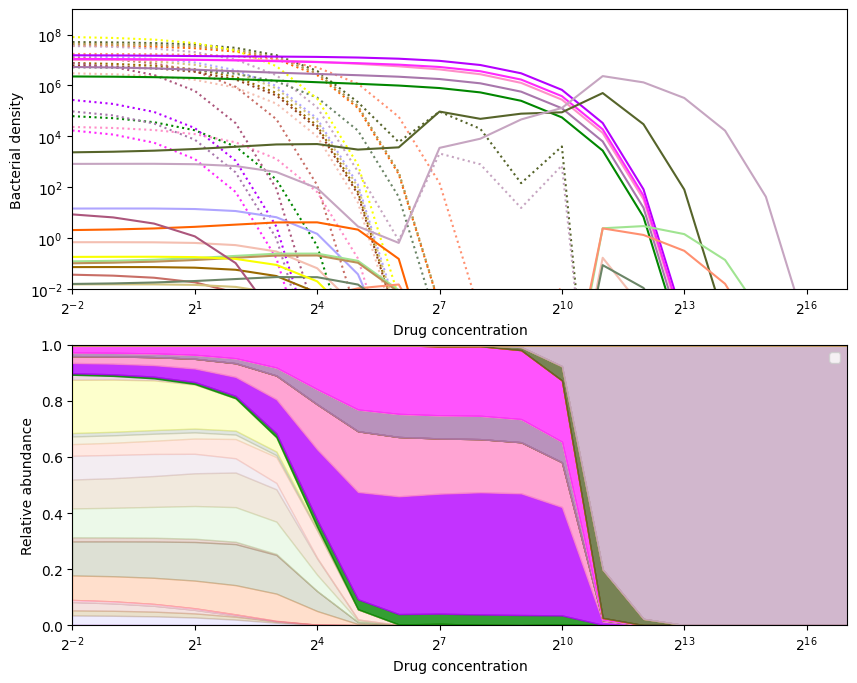

In [20]:

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot dose-response area
plot_doseResponse_multistrain(model_params, istrains2, Amax_values, densities, axs[0])

# Plot dose-response frequencies
plot_doseResponseAreas_multistrain(model_params, istrains2, Amax_values, densities, axs[1])

#plt.tight_layout()
plt.show()

In [21]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

def plot_doseResponseSpecie_multistrain(model_params, istrains, A_values, densities, ax):

    # Create color mapping
    num_strains=int(len(istrains))
    species_list = model_params['specie'].unique()
    color_mapping = {species: cm.get_cmap(color, num_strains) for species, color in zip(species_list, ['Reds', 'Blues'])}

    # Convert densities to a NumPy array
    densities = np.array(densities)

    # Plot WT strains with dotted lines
    for i, strain_index in enumerate(istrains):
        species = model_params.loc[strain_index, 'specie']
        color = color_mapping[species](i)
        ax.plot(A_values, densities[:, i], ':', color=color)

    # Plot TC strains with solid lines
    for i, strain_index in enumerate(istrains):
        species = model_params.loc[strain_index, 'specie']
        color = color_mapping[species](i)
        ax.plot(A_values, densities[:, len(istrains) + i], '-', color=color, linewidth=2)

    ax.set_xlabel('Drug concentration')
    ax.set_ylabel('Bacterial density')
    ax.set_xscale('log', base=2)
    ax.set_yscale('log')
    ax.set_ylim([10**-2, 10**9])
    ax.set_xlim([A_values[0], A_values[-1]])

    ax.legend()

def plot_doseResponseAreaSpecies_multistrain(model_params, istrains, A_values, densities, ax):

    # Create color mapping
    num_strains=int(len(istrains)/2)
    species_list = model_params['specie'].unique()
    color_mapping = {species: cm.get_cmap(color, num_strains) for species, color in zip(species_list, ['Reds', 'Blues'])}

    # Convert densities to a NumPy array
    densities = np.array(densities)
    #densities[densities < 0] = 0

    # Calculate total density at each point
    total_density = np.sum(densities, axis=1)

    # Calculate relative abundance at each point
    relative_abundances = densities / total_density[:, np.newaxis]

    # Plot WT strains with stacked area chart
    cumulative_density = np.zeros_like(total_density)
    for i, strain_index in enumerate(istrains):
        species = model_params.loc[strain_index, 'specie']
        color = color_mapping[species](i)
        ax.fill_between(A_values, cumulative_density, cumulative_density + relative_abundances[:, i]*total_density, color=color, alpha=0.8)
        cumulative_density += relative_abundances[:, i]*total_density

    # Plot TC strains with stacked area chart
    for i, strain_index in enumerate(istrains):
        species = model_params.loc[strain_index, 'specie']
        color = color_mapping[species](i)
        ax.fill_between(A_values, cumulative_density, cumulative_density + relative_abundances[:, len(istrains) + i]*total_density, color=color, alpha=0.8, hatch='//')
        cumulative_density += relative_abundances[:, len(istrains) + i]*total_density

    ax.set_xlabel('Drug concentration')
    ax.set_ylabel('Density')
    ax.set_xscale('log', base=2)
    #ax.set_yscale('log')
    ax.set_ylim([1e-2, 0.5e9])
    ax.set_xlim([A_values[0], A_values[-1]])

    ax.legend()



<ipython-input-21-aad794ec00c4>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_mapping = {species: cm.get_cmap(color, num_strains) for species, color in zip(species_list, ['Reds', 'Blues'])}
<ipython-input-21-aad794ec00c4>:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_mapping = {species: cm.get_cmap(color, num_strains) for species, color in zip(species_list, ['Reds', 'Blues'])}


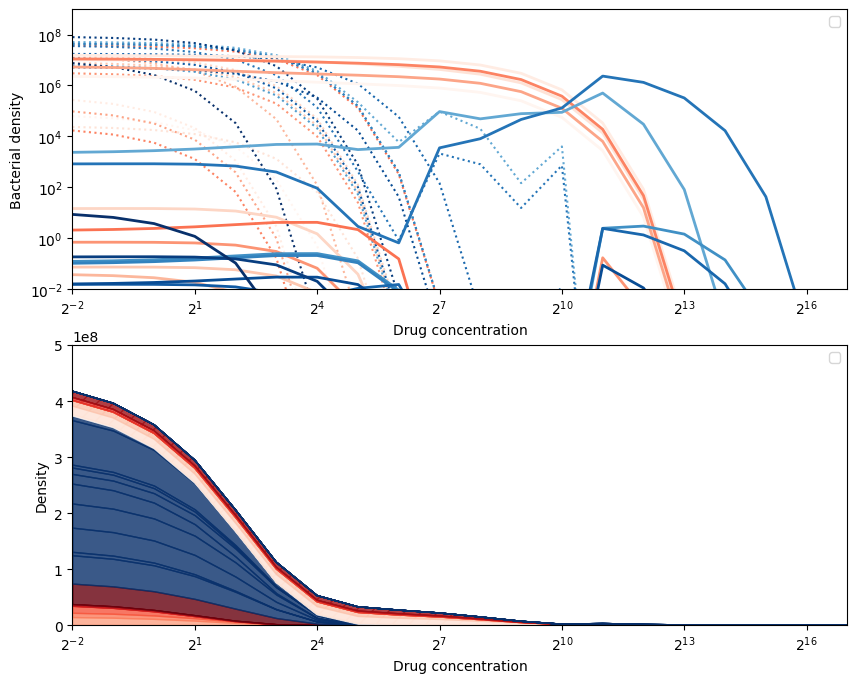

In [22]:

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

plot_doseResponseSpecie_multistrain(model_params, istrains2, Amax_values, densities, axs[0])

plot_doseResponseAreaSpecies_multistrain(model_params, istrains2, Amax_values, densities, axs[1])

#plt.tight_layout()
plt.show()

In [23]:
def plot_fractionPlasmidBearing_multistrain(model_params, istrains, A_values, densities, ax):

    # Create color mapping
    species_list = list(model_params['specie'].unique())
    color_mapping = {species: color for species, color in zip(species_list, ['Red', 'Blue'])}

    # Convert densities to a NumPy array
    densities = np.array(densities)

    # Calculate total density at each point
    total_density = np.sum(densities, axis=1)

    # Calculate relative abundance at each point
    relative_abundances = densities / total_density[:, np.newaxis]

    # Initialize an array for the fraction of plasmid-bearing cells
    fractions_species = np.zeros((len(A_values), len(species_list), 2))  # Added an extra dimension for WT and TC

    # Calculate the fraction of plasmid-bearing cells of each species
    for i, strain_index in enumerate(istrains):
        species = model_params.loc[strain_index, 'specie']
        fractions_species[:, species_list.index(species), 0] += relative_abundances[:, i]  # WT
        fractions_species[:, species_list.index(species), 1] += relative_abundances[:, len(istrains) + i]  # TC

    # Plot fraction of plasmid-bearing cells with area chart
    cumulative_fraction = np.zeros(len(A_values))

    for i, species in enumerate(species_list):
        for j in range(2):  # Loop over WT and TC
            ax.fill_between(A_values, cumulative_fraction, cumulative_fraction + fractions_species[:, i, j],
                            color=color_mapping[species], alpha=0.8 if j == 1 else 0.2,
                            hatch='//' if j == 1 else None)
            cumulative_fraction += fractions_species[:, i, j]

    ax.set_xlabel('Drug concentration')
    ax.set_ylabel('Fraction of plasmid-bearing cells')
    ax.set_xscale('log', base=2)
    ax.set_ylim([0, 1])
    ax.set_xlim([A_values[0], A_values[-1]])

    ax.legend()


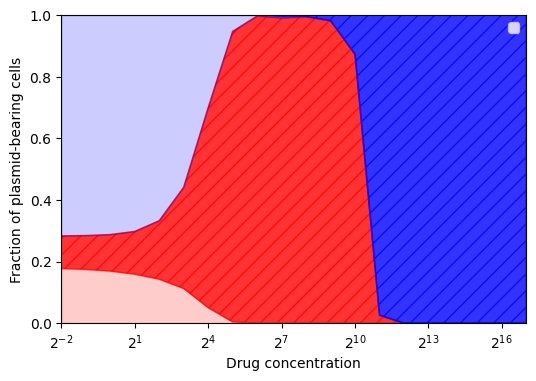

In [24]:

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plot_fractionPlasmidBearing_multistrain(model_params, istrains2, Amax_values, densities, ax)
plt.show()